## Homework 1

Author: Dmitry Petrov, teaching assistant (use to.dmitry.petrov@gmail.com for questions)

Prerequisites: sklearn, pandas, numpy, scipy, ipython/jupyter, xgboost, matplotlib/seaborn libraries for python.

Your report (as ipython-notebook preferebaly) should be prepared by June 17.

The letter with the report should be sent to these emails: to.dmitry.petrov@gmail.com, dmitrii.ignatov@gmail.com, and ivannnnz@gmail.com. The topic of the letter must have the following format [CS-ML2016m-HW1]-LAST NAME-FIRST NAME.

Max mark is 10.


### 0. Data aquisition

Get the training data from 'Walmart Recruiting: Trip Type Classification' competition:
https://www.kaggle.com/c/walmart-recruiting-trip-type-classification/data

Note 1: you can also pass this assignment if you will provide notebook with 0.55 log loss or better result on 10-fold cross-validation. 

Note 2: if this competition is your project, consider this assignment as first steps in it. 



In [1]:
import random
import pandas as pd
import numpy as np
import seaborn as sn
from sklearn import cross_validation
from sklearn import neighbors
from sklearn import metrics
from sklearn import linear_model
from sklearn import svm
from sklearn import ensemble
from sklearn import grid_search
from sklearn import learning_curve
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
%matplotlib inline

I work on 2.2Ghz 4GB machine, so due to performance of my computer I can use only the part of the initial dataset.

In [2]:
random.seed(26L)
train = pd.read_csv("train.csv", skiprows=random.sample(range(1,647054), 640000))

In [3]:
test = pd.read_csv("test.csv")

In [4]:
train.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
0,26,8,Friday,2.238404e+09,2,PAINT AND ACCESSORIES,3565.0
1,15,123,Friday,4.900005e+09,1,DSD GROCERY,9570.0
2,7,137,Friday,7.682805e+09,1,PERSONAL CARE,9110.0
3,7,199,Friday,3.800039e+09,1,GROCERY DRY GOODS,3600.0
4,40,255,Friday,4.400000e+09,2,DSD GROCERY,3713.0


In [5]:
test.head()

,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
0,1,Friday,7.250339e+10,1,SHOES,3002.0
1,1,Friday,1.707711e+09,1,DAIRY,1526.0
2,1,Friday,8.947000e+10,1,DAIRY,1431.0
3,1,Friday,8.849121e+10,1,GROCERY DRY GOODS,3555.0
4,2,Friday,2.840015e+09,1,DSD GROCERY,4408.0


### 1. Preliminary analysis

Give summary of train features. 

— Which of them are numerical and categorical? 

— What distributions do they have? Are distributions identical on test and train? 

— What features contain missing values? What's your guess why?

Note: Pandas library can be very handy.

There are two categorical features: Weekday and DepartmentDescription. All of the rest reatures are numerical.

In [6]:
train.dtypes

TripType                   int64
VisitNumber                int64
Weekday                   object
Upc                      float64
ScanCount                  int64
DepartmentDescription     object
FinelineNumber           float64
dtype: object

In [7]:
train.describe()

,TripType,VisitNumber,Upc,ScanCount,FinelineNumber
count,7054.000000,7054.000000,7.015000e+03,7054.000000,7015.000000
mean,57.958889,97627.339807,3.056004e+10,1.093989,3721.554669
std,155.740643,55427.366221,9.130819e+10,0.727095,2781.448957
min,3.000000,8.000000,8.340000e+02,-2.000000,0.000000
25%,27.000000,50334.250000,3.400001e+09,1.000000,1405.000000
50%,39.000000,98568.500000,7.033072e+09,1.000000,3351.000000
75%,40.000000,145186.000000,2.509770e+10,1.000000,5501.000000
max,999.000000,191347.000000,9.781633e+11,23.000000,9998.000000


In [8]:
test.describe()

,VisitNumber,Upc,ScanCount,FinelineNumber
count,653646.000000,6.496600e+05,653646.000000,649660.000000
mean,97040.992661,3.054325e+10,1.108726,3725.241185
std,55575.161962,9.125453e+10,0.712841,2776.625808
min,1.000000,8.340000e+02,-21.000000,0.000000
25%,49689.000000,3.400001e+09,1.000000,1404.000000
50%,98219.000000,7.047049e+09,1.000000,3353.000000
75%,145271.000000,3.004167e+10,1.000000,5501.000000
max,191348.000000,9.789707e+11,55.000000,9999.000000


The distributions of the features are quite identical on the train and test data.

In [9]:
del test

Upc, DepartmentDescription and FinelineNumber features contain missing values.

In [10]:
train.isnull().any(0)

TripType                 False
VisitNumber              False
Weekday                  False
Upc                       True
ScanCount                False
DepartmentDescription     True
FinelineNumber            True
dtype: bool

### 2. Data preprocessing and feature engineering

— Missing values. How do you choose to impute them? Why?

— String variables. Implement label and one-hot encoding. For what models it makes a difference? (Note: it may be better to use Pandas get_dummies method to one-hot encoder in sklearn).

— Combine observations by VisitNumber (Pandas groupby method can be very handy in that case). Make feature vector for each VisitNumber.  

— Split training data into even new_train and evaluation sets using train_test_split from sklearn. Fix random state for reproducibility of your results. 

— Choose cross-validation 5-fold split for your data (3-fold if your PC is not so fast). Do not forget to specify random state for your results reproducibility. 

For applying the algorithms just exclude the rows with missing data.

In [11]:
train = train.dropna(axis=0)

Check that there are no more missing values in the dataset.

In [12]:
train.isnull().any(0)

TripType                 False
VisitNumber              False
Weekday                  False
Upc                      False
ScanCount                False
DepartmentDescription    False
FinelineNumber           False
dtype: bool

Using Pandas get_dummies method apply one-hot encoding for the categorical features. Also, using Pandas groupby method combine obseravations by VisitNumber and make feature vectors just by taking the means.

In [13]:
train = pd.get_dummies(train)
train = train.groupby('VisitNumber')
train = train.mean()

Using train_test_split from sklearn split the data into new train and test sets.

In [17]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(train.ix[:, train.columns != 'TripType'],
                                                                     train.ix[:, train.columns == 'TripType'], 
                                                                     random_state=26L)

Implement some preprocessing for the data.

In [18]:
X_train = preprocessing.scale(X_train.as_matrix())
X_test = preprocessing.scale(X_test.as_matrix())
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

### 3. KNN-classifier

— Try KNN classifier on the obtained features. Report accuracy and logarithmic loss (mean and std across the folds). How does this evaluation metrics change depending on neighbors number? Depending on distance metric? 

— Show normalized confusion matrix for the best obtained model performance on the evaluation set. How does it differ from cross-validation score?

Let's try KNN classifier with n_neighbors=5 and metric='minkowski'.

In [19]:
clf = neighbors.KNeighborsClassifier(n_neighbors=5, metric='minkowski')
accuracy = cross_validation.cross_val_score(clf, X_train, y_train, scoring='accuracy')
log_loss = cross_validation.cross_val_score(clf, X_train, y_train, scoring='log_loss')
accuracy1 = accuracy.mean()
accuracyStd = accuracy.std()
log_loss1 = -log_loss.mean()
log_lossStd = log_loss.std()
print 'Accuracy: '+str(accuracy1)+' +/- '+str(accuracyStd)
print 'Log_loss: '+str(log_loss1)+' +/- '+str(log_lossStd)

Accuracy: 0.237553360436 +/- 0.00701448037949
Log_loss: 16.1583442796 +/- 0.292657867274


Let's try chebyshev metric instead of minkowski.

In [20]:
clf = neighbors.KNeighborsClassifier(n_neighbors=5, metric='chebyshev')
accuracy = cross_validation.cross_val_score(clf, X_train, y_train, scoring='accuracy')
log_loss = cross_validation.cross_val_score(clf, X_train, y_train, scoring='log_loss')
accuracy2 = accuracy.mean()
accuracyStd = accuracy.std()
log_loss2 = -log_loss.mean()
log_lossStd = log_loss.std()
print 'Accuracy: '+str(accuracy2)+' +/- '+str(accuracyStd)
print 'Log_loss: '+str(log_loss2)+' +/- '+str(log_lossStd)

Accuracy: 0.235923472742 +/- 0.0032124448402
Log_loss: 16.4535056065 +/- 0.245226249218


The results are worse. Switch back to minkowski metric and try to increase n_neighbors to 30.

In [21]:
clf = neighbors.KNeighborsClassifier(n_neighbors=30, metric='minkowski')
accuracy = cross_validation.cross_val_score(clf, X_train, y_train, scoring='accuracy')
log_loss = cross_validation.cross_val_score(clf, X_train, y_train, scoring='log_loss')
accuracy3 = accuracy.mean()
accuracyStd = accuracy.std()
log_loss3 = -log_loss.mean()
log_lossStd = log_loss.std()
print 'Accuracy: '+str(accuracy3)+' +/- '+str(accuracyStd)
print 'Log_loss: '+str(log_loss3)+' +/- '+str(log_lossStd)

Accuracy: 0.291740701143 +/- 0.0116929086083
Log_loss: 7.09993158418 +/- 0.0960761599923


Results are better, but it takes more time for computing. Visualize normalized confusion matrix for the last model and compute the accuracy on the evaluation sets.

Accuracy: 0.293242405456


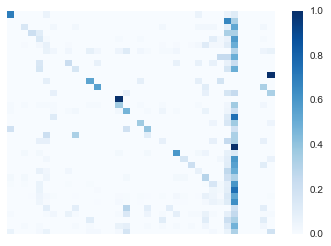

In [22]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
print 'Accuracy: '+str(accuracy)
cm = metrics.confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cm)
plt.figure()
sn.heatmap(df_cm, cmap='Blues', xticklabels=False, yticklabels=False)

The accuracy obtained on the evaluation sets is a little different than the accuracy obtained on the cross-validation. It also should be noticed that tere is one bad class, which the most frequently predicted. Such picture will be further as well.

### 4. Linear models 

— Try logistic regression and linear SVM on your features. Report accuracy and log loss. Compare it to KNN-classifier. How does performance differ whether you use data scaling or not? How does performance differ if you use on-hot or label encoded categorical features?

— Regularization. Play with l1 and l2 regularization parameters. Plot log loss score depending on different C values for l1 and l2 regularizations. What regualarization do you choose with which parameter? Why? 

— Show normalized confusion matrix for the best obtained model performance on the evaluation set. How does it differ from cross-validation score?

Trying logistic regression with l1 and l2 panalties and for different C values.

In [24]:
log_acc_l2 = []
lod_log_l2 = []
for c in [0.01, 0.2, 0.4, 0.6, 0.8, 1.0]:
    clf = linear_model.LogisticRegression(penalty='l2', C=c)
    accuracy = cross_validation.cross_val_score(clf, X_train, y_train, scoring='accuracy')
    log_loss = cross_validation.cross_val_score(clf, X_train, y_train, scoring='log_loss')
    log_acc_l2.append(accuracy.mean())
    lod_log_l2.append(-log_loss.mean())

In [25]:
log_acc_l1 = []
lod_log_l1 = []
for c in [0.01, 0.2, 0.4, 0.6, 0.8, 1.0]:
    clf = linear_model.LogisticRegression(penalty='l1', C=c)
    accuracy = cross_validation.cross_val_score(clf, X_train, y_train, scoring='accuracy')
    log_loss = cross_validation.cross_val_score(clf, X_train, y_train, scoring='log_loss')
    log_acc_l1.append(accuracy.mean())
    lod_log_l1.append(-log_loss.mean())

Plotting obtained metrics.

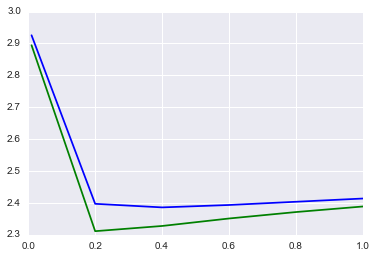

In [28]:
plt.plot([0.01, 0.2, 0.4, 0.6, 0.8, 1.0], lod_log_l2, 'b',
         [0.01, 0.2, 0.4, 0.6, 0.8, 1.0], lod_log_l1, 'g')

Based on the plot the best possibility is to use l1 penalty with C=0.2. i.e. quite strong l1 penalization.

Let's also try the linear SVM algorithm.

In [29]:
clf = svm.SVC(kernel='linear', probability=True)
accuracy = cross_validation.cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=2)
log_loss = cross_validation.cross_val_score(clf, X_train, y_train, scoring='log_loss', cv=2)
accuracy5 = accuracy.mean()
accuracyStd = accuracy.std()
log_loss5 = -log_loss.mean()
log_lossStd = log_loss.std()
print 'Accuracy: '+str(accuracy5)+' +/- '+str(accuracyStd)
print 'Log_loss: '+str(log_loss5)+' +/- '+str(log_lossStd)

Accuracy: 0.318410924012 +/- 0.00915397091972
Log_loss: 2.47686164751 +/- 0.00623459067038


It takes very long time, but there is no so much difference in perfomance comparing with logistic regression.

Plotting normalized confusion matrix for the best logistic regression model and compute the accuracy on the evaluation sets.

Accuracy: 0.332300061996


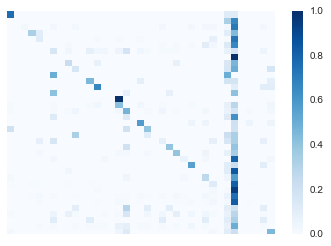

In [49]:
clf = linear_model.LogisticRegression(penalty='l1', C=0.2)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
print 'Accuracy: '+str(accuracy)
cm = metrics.confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cm)
plt.figure()
sn.heatmap(df_cm, cmap='Blues', xticklabels=False, yticklabels=False)

### 5. Tree-based models

— Try vanilla Random Forest, AdaBoost, GBDT from sklearn and GBDT from xgboost. Report cross-validation log loss (mean and std) for each of these models.

— Random Forest. Find best parameters for the Random Forest using grid search on cross-validation. Which of them are the most important? Report result on evaluation test. 

— Adaboost. Find the best values of parameters for the AdaBoost using grid search on cross-validation. Which of them are the most important? Plot learning curve (log loss on each conscutive iteration) for the best AdaBoost on new_train and evaluation sets. Note: staged_predict_proba method can be very useful. 

— GBDT. Compare speed and performance of sklearn/xgboost GBDT implementation with similar parameters. Which implementation do your choose? Do not forget to utilise all of your CPUs/threads to speed up calculations. Find best parameters for the GBDT using grid search on cross-validation. What are the most important? Plot learning curve (log loss on each consecutive iteration) for the best GBDT on new_train and evaluation sets. Note: staged_predict_proba method can be very useful for sklearn and evals_result method for xgboost.


#### Random Forest

Implementing grid search for Random Forest.

In [31]:
rf = ensemble.RandomForestClassifier()
parameters = {'n_estimators':[10, 50, 150], 'criterion':('gini', 'entropy')}
clf = grid_search.GridSearchCV(rf, parameters, cv=2)
clf.fit(X_train, y_train)
clf.best_params_

{'criterion': 'gini', 'n_estimators': 50}

The best parameteres are shown above.

Checking the model with best parameters on cross-validation.

In [52]:
rf = ensemble.RandomForestClassifier(n_estimators=50, criterion='gini')
accuracy = cross_validation.cross_val_score(rf, X_train, y_train, scoring='accuracy')
log_loss = cross_validation.cross_val_score(rf, X_train, y_train, scoring='log_loss')
accuracy6 = accuracy.mean()
accuracyStd = accuracy.std()
log_loss6 = -log_loss.mean()
log_lossStd = log_loss.std()
print 'Accuracy: '+str(accuracy6)+' +/- '+str(accuracyStd)
print 'Log_loss: '+str(log_loss6)+' +/- '+str(log_lossStd)

Accuracy: 0.26034226505 +/- 0.00683771313148
Log_loss: 9.42991637314 +/- 0.062799137989


Applying to evaluation sets.

In [53]:
rf = ensemble.RandomForestClassifier(n_estimators=50, criterion='gini')
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
print 'Accuracy: '+str(accuracy)

Accuracy: 0.265344079355


#### Adaboost

Implementing grid search for Adaboost.

In [32]:
ada = ensemble.AdaBoostClassifier()
parameters = {'algorithm':('SAMME', 'SAMME.R'), 'n_estimators':[50, 70, 150]}
clf = grid_search.GridSearchCV(ada, parameters, cv=2)
clf.fit(X_train, y_train)
clf.best_params_

{'algorithm': 'SAMME.R', 'n_estimators': 50}

The best parameteres are shown above.

Checking the model with best parameters on cross-validation.

In [54]:
ada = ensemble.AdaBoostClassifier(algorithm = 'SAMME.R', n_estimators = 50)
accuracy = cross_validation.cross_val_score(ada, X_train, y_train, scoring='accuracy')
log_loss = cross_validation.cross_val_score(ada, X_train, y_train, scoring='log_loss')
accuracy7 = accuracy.mean()
accuracyStd = accuracy.std()
log_loss7 = -log_loss.mean()
log_lossStd = log_loss.std()
print 'Accuracy: '+str(accuracy7)+' +/- '+str(accuracyStd)
print 'Log_loss: '+str(log_loss7)+' +/- '+str(log_lossStd)

Accuracy: 0.273309810009 +/- 0.00951515416253
Log_loss: 3.51302945317 +/- 0.00390904056625


Plotting learning curve on evaluation sets.

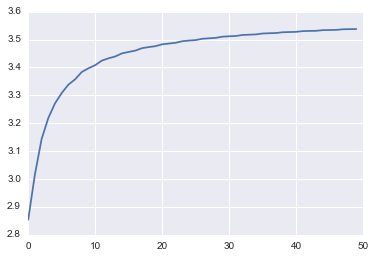

In [49]:
ada = ensemble.AdaBoostClassifier(algorithm = 'SAMME.R', n_estimators = 50)
ada.fit(X_train, y_train)
y_stage = ada.staged_predict_proba(X_test)
learn_curve = []
for y_pred in y_stage:
    learn_curve.append(metrics.log_loss(y_test, y_pred))
plt.plot(learn_curve)

#### GBDT

Implementing grid search for GBDT (sklearn).

In [37]:
gbdt = ensemble.GradientBoostingClassifier()
parameters = {'max_depth':[1,3], 'n_estimators':[100, 150]}
clf = grid_search.GridSearchCV(gbdt, parameters, cv=2)
clf.fit(X_train, y_train)
clf.best_params_

{'max_depth': 1, 'n_estimators': 150}

The best parameteres are shown above.

Checking the model with best parameters on cross-validation.

In [56]:
gbdt = ensemble.GradientBoostingClassifier(max_depth = 1, n_estimators = 150)
accuracy = cross_validation.cross_val_score(gbdt, X_train, y_train, scoring='accuracy',cv=2)
log_loss = cross_validation.cross_val_score(gbdt, X_train, y_train, scoring='log_loss',cv=2)
accuracy8 = accuracy.mean()
accuracyStd = accuracy.std()
log_loss8 = -log_loss.mean()
log_lossStd = log_loss.std()
print 'Accuracy: '+str(accuracy8)+' +/- '+str(accuracyStd)
print 'Log_loss: '+str(log_loss8)+' +/- '+str(log_lossStd)

Accuracy: 0.327946139349 +/- 0.00291500609837
Log_loss: 2.35625286102 +/- 0.00759054292157


Plotting learning curve on evaluation sets.

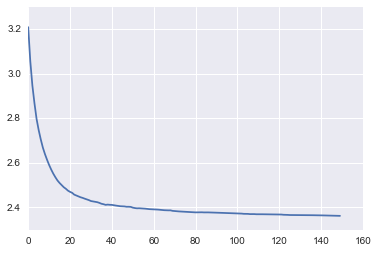

In [50]:
gbdt = ensemble.GradientBoostingClassifier(max_depth = 1, n_estimators = 150)
gbdt.fit(X_train, y_train)
y_stage = gbdt.staged_predict_proba(X_test)
learn_curve = []
for y_pred in y_stage:
    learn_curve.append(metrics.log_loss(y_test, y_pred))
plt.plot(learn_curve)

### 6. Model comaprison and combination

— Compare performance of all used models in terms of accuracy and log loss on evaluation. What is the best single model performance?

— (optional) Try to imporve your single model performnace with weighted combination of other models predictions. Note: sklearn VotingClassifier with 'softmax' option can be useful. What is the best model performance on evaluation?

The performance of all the models with the best parameters is presented in the summary table below.

In [61]:
results = [[accuracy3,log_loss3],[log_acc_l1[1],lod_log_l1[1]],[accuracy5,log_loss5],
           [accuracy6,log_loss6],[accuracy7,log_loss7],[accuracy8,log_loss8]]
results = np.transpose(results)
pd.DataFrame(results, index = ['accuracy', 'log_loss'],
             columns=['KNN Classifier', 'Logistic Regression', 'Linear SVM',
                      'Random Forest', 'Adaboost', 'GBDT'])

,KNN Classifier,Logistic Regression,Linear SVM,Random Forest,Adaboost,GBDT
accuracy,0.291741,0.333929,0.318411,0.260342,0.273310,0.327946
log_loss,7.099932,2.311369,2.476862,9.429916,3.513029,2.356253


So, the best two algorithms here are Logistic Regression and GBDT.

Let,s try to improve the performance by combining three best models.

In [66]:
gbdt = ensemble.GradientBoostingClassifier(max_depth = 1, n_estimators = 150)
lr = linear_model.LogisticRegression(penalty='l1', C=0.2)
ada = ensemble.AdaBoostClassifier(algorithm = 'SAMME.R', n_estimators = 50)
clfs = [('gbdt',gbdt),('lr',lr),('ada',ada)]
vclf = ensemble.VotingClassifier(clfs, voting = 'soft')
accuracy = cross_validation.cross_val_score(vclf, X_train, y_train, scoring='accuracy',cv=2)
log_loss = cross_validation.cross_val_score(vclf, X_train, y_train, scoring='log_loss',cv=2)
accuracy = accuracy.mean()
log_loss = -log_loss.mean()
print 'Accuracy: '+str(accuracy)
print 'Log_loss: '+str(log_loss)

Accuracy: 0.332290940288
Log_loss: 2.45311428915


Unfortunately, there is no considerable improvement here.